#Installing library and downloading datasets

In [1]:
# change if not installed locally
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-lifestream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 KB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 KB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os

if not os.path.exists('data/transactions.csv'):
    ! mkdir -p data
    ! curl -OL https://storage.yandexcloud.net/datasouls-ods/materials/0433a4ca/transactions.zip
    ! curl -OL https://storage.yandexcloud.net/datasouls-ods/materials/0554f0cf/clickstream.zip
    ! curl -OL https://storage.yandexcloud.net/datasouls-ods/materials/e756bf99/train.csv
    ! unzip clickstream.zip -d data
    ! unzip transactions.zip -d data
    ! cp train.csv data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  250M  100  250M    0     0  9202k      0  0:00:27  0:00:27 --:--:-- 10.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  469M  100  469M    0     0  9836k      0  0:00:48  0:00:48 --:--:-- 10.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  307k  100  307k    0     0   130k      0  0:00:02  0:00:02 --:--:--  130k
Archive:  clickstream.zip
  inflating: data/clickstream.csv    
Archive:  transactions.zip
  inflating: data/transactions.csv   
  inflating: data/__MACOSX/._transactions.csv  


#Preprocessing of the transactions dataset

In [2]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl
# import warnings

# warnings.filterwarnings('ignore')
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [3]:
import os
import pandas as pd

data_path = 'data/'

source_data = pd.read_csv(os.path.join(data_path, 'transactions.csv'))
source_data.head(2)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40


In [ ]:
source_data.shape

(19821910, 5)

In [4]:
source_data.transaction_dttm = pd.to_datetime(source_data.transaction_dttm)

In [5]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='user_id',
    col_event_time='transaction_dttm',
    event_time_transformation='dt_to_timestamp',
    cols_category=['mcc_code','currency_rk'],
    cols_numerical=['transaction_amt'],
    return_records=True,
)

In [6]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 1min 9s, sys: 12.9 s, total: 1min 22s
Wall time: 1min 22s


In [7]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [8]:
preprocessor.get_category_dictionary_sizes()

{'mcc_code': 388, 'currency_rk': 6}

In [9]:
dataset = sorted(dataset, key=lambda x: x['user_id'])

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(18026, 4507)

#Creating the model

In [11]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'transaction_amt': 'identity'},
    embeddings={
        'event_time': {'in': 800, 'out': 16},
        'mcc_code': {'in': 400, 'out': 16},
        'currency_rk':{'in': 6, 'out': 2}
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=129,
    type='gru',
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

#Dataloader creation

In [12]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    train_num_workers=2,
    train_batch_size=256,
)

#Training procedure

In [13]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=15,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [14]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


logger.version = 0


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 83.6 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
83.6 K    Trainable params
0         Non-trainable params
83.6 K    Total params
0.334     Total estimated model params size (MB)


{'loss': tensor(133.6564), 'seq_len': tensor(116.4340)}
CPU times: user 2min 36s, sys: 23.5 s, total: 3min
Wall time: 4min 14s


#Creation of the embeddings

In [15]:
from ptls.data_load.datasets import inference_data_loader

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([18026, 129]), torch.Size([4507, 129]))

#Creation of pandas dataframes with target

In [16]:
df_target = pd.read_csv(os.path.join(data_path, 'train.csv'))
df_target.rename(columns={'bank':'user_id'},inplace=True)
df_target = df_target.set_index('user_id')
df_target.rename(columns={"bins": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['user_id'] = [x['user_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='user_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['user_id'] = [x['user_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='user_id')

print(train_df.shape, test_df.shape)

(18026, 131) (4507, 131)


In [17]:
# Dropping nan values, that appears while merging embeddings and
# target, as there is target not for each user in datasets
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [18]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['higher_education']
x_test, y_test = test_df[embed_columns], test_df['higher_education']

In [19]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 16.4 MB/s eta 0:00:00


#Catboost model creation for using in downstream task

In [20]:
from catboost import CatBoostClassifier, metrics
CatBoostModel = CatBoostClassifier(
iterations= 500,
learning_rate = 0.05,
use_best_model = True,
eval_metric ='AUC', 
loss_function='Logloss',
random_seed = 42,
logging_level = 'Silent',
depth = 5)

#Training procedure

In [21]:
CatBoostModel.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    plot=True
#     logging_level='Verbose',  # you can uncomment this for text output
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
CatBoostModel.get_best_score()

{'learn': {'Logloss': 0.3093552097272859},
 'validation': {'Logloss': 0.484640102186229, 'AUC': 0.7653506474066313}}

In [23]:
y_pred = CatBoostModel.predict(x_test)
y_proba = CatBoostModel.predict_proba(x_test)

#Achieving metrics

In [24]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

print(f'''accuracy: {CatBoostModel.score(x_test, y_test)} 
      f1: {f1_score(y_pred, y_test)}, 
      precision: {precision_score(y_pred, y_test)}
     roc auc : {roc_auc_score(y_test, y_proba[:,1])}''')

accuracy: 0.7612208258527827 
      f1: 0.8503937007874016, 
      precision: 0.9145161290322581
     roc auc : 0.7653506474066312


#Experiment with different size of embeddings

In [27]:
roc_auc_list = []
embed_sizes = [32,64,96,128,256,512,1024]

In [28]:
for embed_size in embed_sizes:

  trx_encoder_params = dict(
      embeddings_noise=0.003,
      numeric_values={'transaction_amt': 'identity'},
      embeddings={
          'event_time': {'in': 800, 'out': 16},
          'mcc_code': {'in': 400, 'out': 16},
          'currency_rk':{'in': 6, 'out': 2}
      },
  )

  seq_encoder = RnnSeqEncoder(
      trx_encoder=TrxEncoder(**trx_encoder_params),
      hidden_size=embed_size,
      type='gru',
  )

  model = CoLESModule(
      seq_encoder=seq_encoder,
      optimizer_partial=partial(torch.optim.Adam, lr=0.001),
      lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
  )



  train_dl = PtlsDataModule(
      train_data=ColesDataset(
          MemoryMapDataset(
              data=train,
              i_filters=[
                  SeqLenFilter(min_seq_len=25),
              ],
          ),
          splitter=SampleSlices(
              split_count=5,
              cnt_min=25,
              cnt_max=200,
          ),
      ),
      train_num_workers=2,
      train_batch_size=256,
  )



  trainer = pl.Trainer(
      max_epochs=15,
      gpus=1 if torch.cuda.is_available() else 0,
      enable_progress_bar=False,
  )

  print(f'logger.version = {trainer.logger.version}')
  trainer.fit(model, train_dl)
  print(trainer.logged_metrics)


  train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
  train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

  test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
  test_embeds = torch.vstack(trainer.predict(model, test_dl))

  train_embeds.shape, test_embeds.shape

  df_target = pd.read_csv(os.path.join(data_path, 'train.csv'))
  df_target.rename(columns={'bank':'user_id'},inplace=True)
  df_target = df_target.set_index('user_id')
  df_target.rename(columns={"bins": "target"}, inplace=True)

  train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
  train_df['user_id'] = [x['user_id'] for x in train]
  train_df = train_df.merge(df_target, how='left', on='user_id')

  test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
  test_df['user_id'] = [x['user_id'] for x in test]
  test_df = test_df.merge(df_target, how='left', on='user_id')

  print(train_df.shape, test_df.shape)

  train_df.dropna(inplace=True)
  test_df.dropna(inplace=True)

  embed_columns = [x for x in train_df.columns if x.startswith('embed')]
  x_train, y_train = train_df[embed_columns], train_df['higher_education']
  x_test, y_test = test_df[embed_columns], test_df['higher_education']


  from catboost import CatBoostClassifier, metrics
  CatBoostModel = CatBoostClassifier(
  iterations= 500,
  learning_rate = 0.05,
  use_best_model = True,
  eval_metric ='AUC', 
  loss_function='Logloss',
  random_seed = 42,
  logging_level = 'Silent',
  depth = 5)

  CatBoostModel.fit(
      x_train, y_train,
      eval_set=(x_test, y_test),
      plot=True
  #     logging_level='Verbose',  # you can uncomment this for text output
  )

  CatBoostModel.get_best_score()

  y_pred = CatBoostModel.predict(x_test)
  y_proba = CatBoostModel.predict_proba(x_test)


  print(f'''accuracy: {CatBoostModel.score(x_test, y_test)} 
        f1: {f1_score(y_pred, y_test)}, 
        precision: {precision_score(y_pred, y_test)}
      roc auc : {roc_auc_score(y_test, y_proba[:,1])}''')
  roc_auc_list.append(roc_auc_score(y_test, y_proba[:,1]))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 25.9 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

logger.version = 1


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(157.7389), 'seq_len': tensor(113.5962)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 34) (4507, 34)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 38.7 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7636146020347098 
        f1: 0.8516710476905746, 
        precision: 0.9145161290322581
      roc auc : 0.7400325574433051
logger.version = 2


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(145.6334), 'seq_len': tensor(112.2604)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 66) (4507, 66)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 57.6 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.767803710353082 
        f1: 0.8576669112252385, 
        precision: 0.942741935483871
      roc auc : 0.76125477134945
logger.version = 3


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(139.9775), 'seq_len': tensor(113.8660)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 98) (4507, 98)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 82.7 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7749850388988629 
        f1: 0.8583270535041447, 
        precision: 0.9185483870967742
      roc auc : 0.7586782426465085
logger.version = 4


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(137.3579), 'seq_len': tensor(115.9132)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 130) (4507, 130)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 244 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7690005984440454 
        f1: 0.8542296072507554, 
        precision: 0.9120967741935484
      roc auc : 0.7656911907791333
logger.version = 5


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(135.6201), 'seq_len': tensor(114.8453)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 258) (4507, 258)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 862 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7624177139437462 
        f1: 0.851588785046729, 
        precision: 0.9185483870967742
      roc auc : 0.765457301100217
logger.version = 6


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(135.0447), 'seq_len': tensor(113.6906)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(18026, 514) (4507, 514)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 3.3 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.765409934171155 
        f1: 0.8540580789277735, 
        precision: 0.925
      roc auc : 0.7661121922011827
logger.version = 7


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'loss': tensor(139.3199), 'seq_len': tensor(108.4660)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: ignored

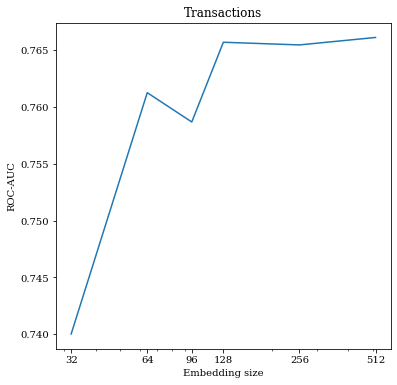

In [45]:
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(6,6))

plt.title('Transactions',fontfamily='serif')
plt.xlabel('Embedding size',fontfamily='serif')
plt.plot(embed_sizes[:-1],roc_auc_list)
plt.ylabel('ROC-AUC',fontfamily='serif')
plt.xscale('log')
plt.xticks(embed_sizes[:-1],fontfamily='serif')
plt.yticks(fontfamily='serif')
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.show()